## FFT

カジュアルに言うとフーリエ変換(FFT)は波形データからどの周期で揺れているかを抽出する変換をさします。工学の振動系とかだと、ノイズが混じった観測データから物体固有の振動を取り出したりとかに使ったり、まあ色々使われます。

この notebook は FFT を使ってサンプルの波形の解析をやって、最後に日経平均の特性をちょっと見てみましょう、というのが主旨になっています。

### FFT Module

python でフーリエ変換のモジュールというと有名なのは `numpy.fft` で基本的には 

* `fftn`: 波形空間からフーリエ変換した強度空間への射影を行う関数
* `ifftn`: フーリエ変換された強度から元の波形空間へ戻す関数
* `fftfreq`: フーリエ変換した強度関数がどの周波数に対応しているかの周波数を計算する関数

の3つを使うことが多い印象です。 `scipy` のほうが早いらしいので変換がボトルネックになるような巨大データを扱うときは numpy からそちらに移行することも考えてみてください。

In [1]:
import numpy as np
from numpy.fft import fftn, ifftn, fftfreq

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

output_dir = './fft_vis'
os.makedirs(output_dir, exist_ok=True)

In [2]:
def save_fig(fig, name):
    p = os.path.join(output_dir, name)
    print(f'save to {p}')
    fig.tight_layout()
    fig.savefig(p, dpi=120)

### サンプルデータの準備

始めにサンプルの周期的な関数を使って、動作を確認してみます。

仮に周期が `3` の波にランダムなノイズが乗っているものを考えてみます。  
周期が 3 の波を作るためには, 適当な x に対して, $1 / 3 \times 2 \pi * x$  を計算すればOKです。

今回は周期が 3 と 0.5 の波を足し合わせたものにガウスノイズをちょっと加えたものを分析対象にします。強度はそれぞれ 1, 0.7, 0.3 としています。

In [3]:
# データの総数
n_samples = 300

# 単位時間あたりに, いくつのデータ点が存在しているか. 
sampling_rate = 10
# サンプルデータ作成のために, 1 / sampling_rate ごとの等間隔な x を用意
x = np.arange(n_samples) / sampling_rate
# 作成した x を入力として, 周期 3 と 0.5 の波形 (+ノイズ) を足し合わせる.
y = np.sin(1 / 3 * 2 * np.pi * x) + .7 * np.sin(2 * 2 * np.pi * x) + .3 * np.random.normal(size=n_samples)

# あとでの遊びのために 10 のところでわざとピークをつける
y += np.where(x == 10, 5, 0)

save to ./fft_vis/sample_wave.png


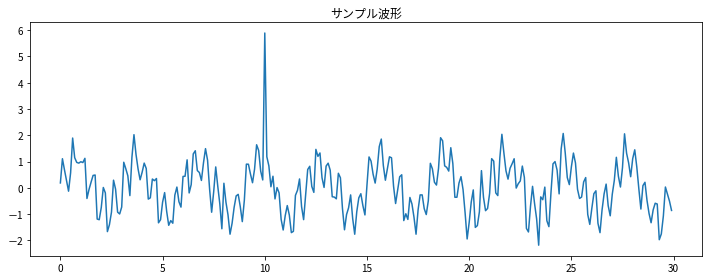

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y)

ax.set_title('サンプル波形')
save_fig(fig, name='sample_wave.png')

実際にフーリエ変換してみます。

フーリエ変換する関数は `fftn` です。普通に使うには波形データを代入すればOKです。

出力は周波数ごとの強度になっているので、どの周波数に対応するか計算する必要があります。  
これを助けてくれるのが `fftfreq` です。波形データの総数とサンプリングレート (Hz) を d に代入します。 
> d は一秒間のデータ数の逆数であることに注意して下さい。

In [5]:
z = fftn(y)
freq = fftfreq(n_samples, d=1 / sampling_rate)

### FFT の出力のみかた

FFT は元の空間の出力値から, 各周波数ごとの強度に変換します。

一般に横軸に周波数もしくは周期をとり、縦軸にその周波数での強度を取ることが多いです。

強度各周波数ごとに出力されますが, どのぐらい綺麗な sin からずれているかの位相遅れ成分が含まれている為, 複素数で表現されています。そのため強度として表示する際には絶対値を取ることが多いです。またその際 logscale にして表示するのが一般的です。(マグニチュードとかと同じ)

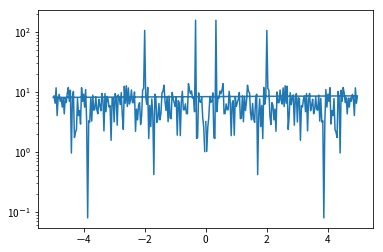

In [6]:
# ノリのような表示
plt.plot(freq, abs(z))
plt.yscale('log')

save to ./fft_vis/sample_wave_fft.png


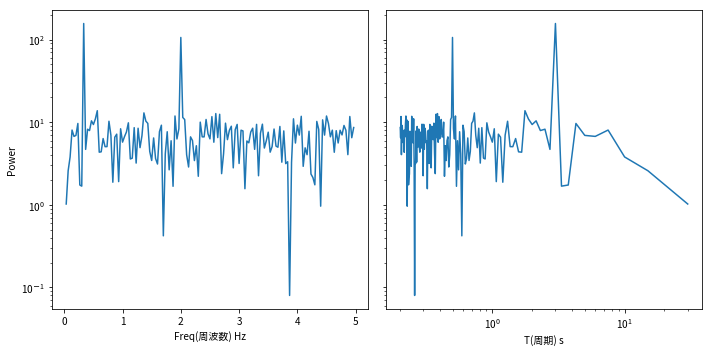

In [7]:
# 真面目に
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
ax = axes[0]
ax.plot(freq[1:int(n_samples / 2)], abs(z[1:int(n_samples / 2)]))
ax.set_yscale('log')
ax.set_xlabel('Freq(周波数) Hz')
ax.set_ylabel('Power')

# 周波数 f → 周期 T に直して表示する
# 周期は fT = 1 を満たすので単に逆数にすれば良い
ax = axes[1]
ax.plot(1 / freq[1:int(n_samples / 2)], abs(z[1:int(n_samples / 2)]))
ax.set_yscale('log')
ax.set_xlabel('T(周期) s')
ax.set_xscale('log')

save_fig(fig, name='sample_wave_fft.png')

In [8]:
fft_pow_df = pd.DataFrame([1 / freq[1:int(n_samples / 2)], np.log10(abs(z[1:int(n_samples / 2)]))], index=['T', 'log10_power']).T
fft_pow_df.sort_values('log10_power', ascending=False).head(10)

T  log10_power
9    3.000000     2.193971
59   0.500000     2.025059
16   1.764706     1.138867
40   0.731707     1.112277
77   0.384615     1.104138
79   0.375000     1.095533
56   0.526316     1.074998
134  0.222222     1.074613
121  0.245902     1.071114
146  0.204082     1.068658

In [9]:
np.log10(1 / 0.7)

0.15490195998574316

### 考察

ちゃんと周期が 3 と 0.5 のところにピークが有ることがわかります。

ログスケールでの強度の差分は大体 0.15 で作成した時の強度の比の log10 の値 `log_10(1/.07)` とほぼ一致していることも確認出来ます。

## IFFT

フーリエ空間から元の波形空間へ戻す。フーリエ変換したあとの情報すべてを使うと、完全に元通り。
この時戻した値の実数値成分 `real` をつかうのをお忘れなく。`ifft` の返り値は数値計算の誤差で、微妙に複素数成分が含まれた値が帰ってくるので実数値だけを取り出すようにします。(ノルムにしてもいい気がするけれどまあほぼ誤差なので気にしなくても良い?)

save to ./fft_vis/sample_wave__ifft.png


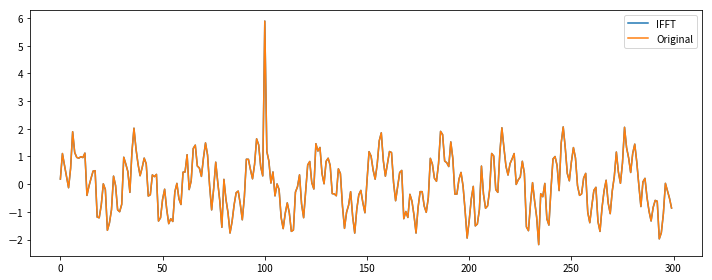

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ifftn(z).real, label='IFFT')
ax.plot(y, label='Original')
ax.legend()

save_fig(fig, name='sample_wave__ifft.png')

## Low Pass Filter

端的に言うと Low な frequency の周波数成分のみを使って IFFT しましょうということです。  
要するに FFT した結果のうち, 周波数が一定以下のゆったりとした波形のみをつかって(反対に言うと高周波の凄い急な振動は消して), もとの波形空間に戻すという方法です。
これをすることで細かい揺れを消すことができるので、波形全体の大まかな傾向をつかむことが出来ます。  
一般にセンサーのノイズとかはホワイトノイズ (np.random.norm) になるためこの影響を小さくして、センサーでとりたい対象本来の波形を抽出するのに使われたりします。

全体の傾向を取ったような関数になるので移動平均と似たなものになる。短期的な変動が消えるので簡易的な異常値検知には使えるかもしれません。  


ためしに先ほどわざと混入させた `x=10` の場所での異常値を検出してみましょう。

save to ./fft_vis/sample_wave__lowpass.png


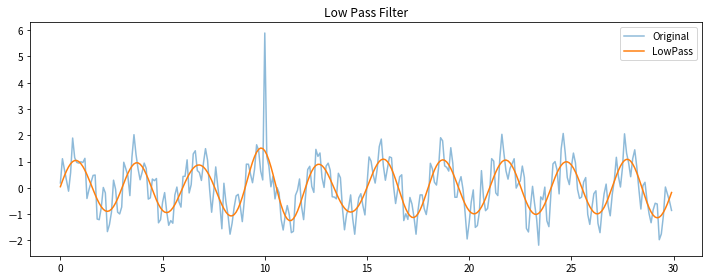

In [11]:
# 2以下の周期を無視する様な lowpass
threshold_period = 2
threshold_freq = 1 / threshold_period

z_lowpass = np.where(abs(freq) > threshold_freq, 0, z)
y_lowpass = ifftn(z_lowpass).real

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, '-', label='Original', alpha=.5)
ax.plot(x, y_lowpass, label='LowPass')
ax.set_title('Low Pass Filter')
ax.legend()

save_fig(fig, name='sample_wave__lowpass.png')

異常値が見たければ元の値と lowpass の差分を見れば良いので適当に引いて絶対値にします。

save to ./fft_vis/sample_wave__diff_lowpass.png


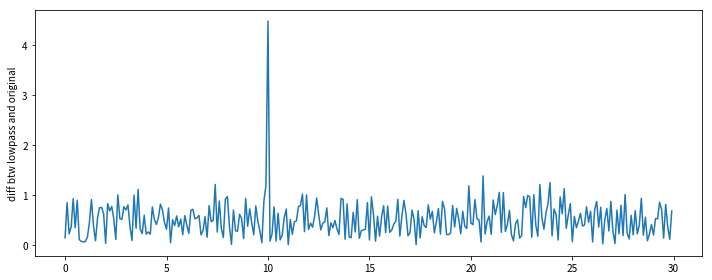

In [12]:
diff = abs(y_lowpass - y)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, diff)
ax.set_ylabel('diff btw lowpass and original')
save_fig(fig, name='sample_wave__diff_lowpass.png')

In [13]:
print(x[np.argmax(diff)])

10.0


ちゃんと 10 のとこに一番異常な点が有ることがだせました。嬉しい:D

## 発展: 日経平均の分析

以上で試したことを日経平均の分析に適用してみましょう。

In [14]:
url = 'https://indexes.nikkei.co.jp/nkave/historical/nikkei_stock_average_daily_jp.csv'
nikkei_df = pd.read_csv(url, encoding='shift_jis')

In [15]:
# 最終行は著作権に関する情報なので切り落とす
nikkei_df = nikkei_df.iloc[:-1, :]

In [16]:
nikkei_df.head()

データ日付        終値        始値        高値        安値
0  2016/01/04  18450.98  18818.58  18951.12  18394.43
1  2016/01/05  18374.00  18398.76  18547.38  18327.52
2  2016/01/06  18191.32  18410.57  18469.38  18064.30
3  2016/01/07  17767.34  18139.77  18172.04  17767.34
4  2016/01/08  17697.96  17562.23  17975.31  17509.64

一旦可視化してみましょう

save to ./fft_vis/nikkei_all.png


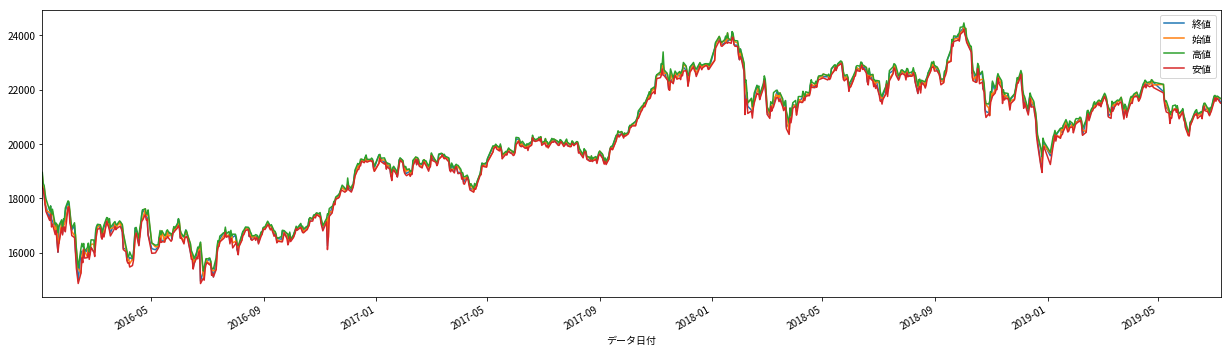

In [17]:
nikkei_df['データ日付'] = pd.to_datetime(nikkei_df['データ日付'])
nikkei_df = nikkei_df.set_index('データ日付')

fig, ax = plt.subplots(figsize=(len(nikkei_df) * .02, 5))
nikkei_df.plot(ax=ax)
save_fig(fig, name='nikkei_all.png')

若干 FFT の仮定である定常的な波 (一定周期で同じ波形を繰り返す) が成り立っているか微妙ですね… 特に始めと終わりの値がずれているのでこのあたりの値の分析には向いてなさそう。

とりあえず、系列はほとんどすべて同じなので、今回は終値を分析対象とします。  
終値データを取り出して, FFT にかけて周波数成分を可視化してみます。

In [18]:
y = nikkei_df['終値'].values
y = y - np.mean(y)
# window = np.hamming(len(y))
# y = y * window
x = nikkei_df.index

In [19]:
n = len(y)
z = fftn(y)
# 単位時間は日でサンプリングレートも1なので `d=1` を指定
freq = fftfreq(n, d=1)

save to ./fft_vis/nikkei_fft.png


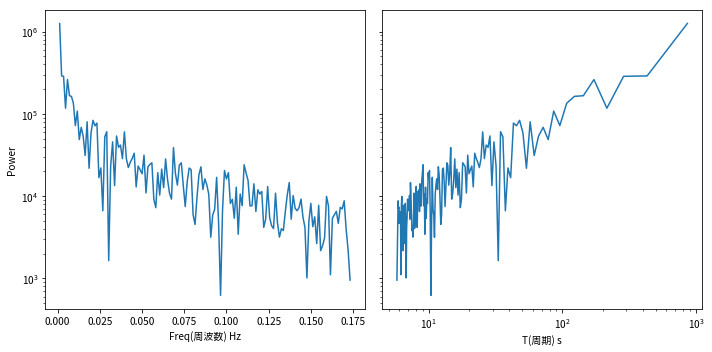

In [20]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
ax = axes[0]
ax.plot(freq[1:int(n_samples / 2)], abs(z[1:int(n_samples / 2)]))
ax.set_yscale('log')
ax.set_xlabel('Freq(周波数) Hz')
ax.set_ylabel('Power')

# 周波数 f → 周期 T に直して表示する
# 周期は fT = 1 を満たすので単に逆数にすれば良い
ax = axes[1]
ax.plot(1 / freq[1:int(n_samples / 2)], abs(z[1:int(n_samples / 2)]))
ax.set_yscale('log')
ax.set_xlabel('T(周期) s')
ax.set_xscale('log')

save_fig(fig, name='nikkei_fft.png')

In [21]:
nikkei_pow_df = pd.DataFrame([1 / freq[1:int(n_samples / 2)], np.log10(abs(z[1:int(n_samples / 2)]))], index=['T', 'log10_power']).T
nikkei_pow_df.sort_values('log10_power', ascending=False).head(10)

T  log10_power
0   860.000000     6.098400
1   430.000000     5.461296
2   286.666667     5.456172
4   172.000000     5.416735
5   143.333333     5.220405
6   122.857143     5.212416
7   107.500000     5.128081
3   215.000000     5.068687
9    86.000000     5.033504
17   47.777778     4.920812

### 結果と考察

* 長周期の成分が大きい。定期的な繰り返しというよりは大きく平均値が変わるような変動をしている。見ればわかるが数値的に分かるのは嬉しいかも。
* 意外と一週間とかの周期は出てこない。

Low Pass Filter もやってみましょう

save to ./fft_vis/nikkei_diff_lowpass_and_original.png


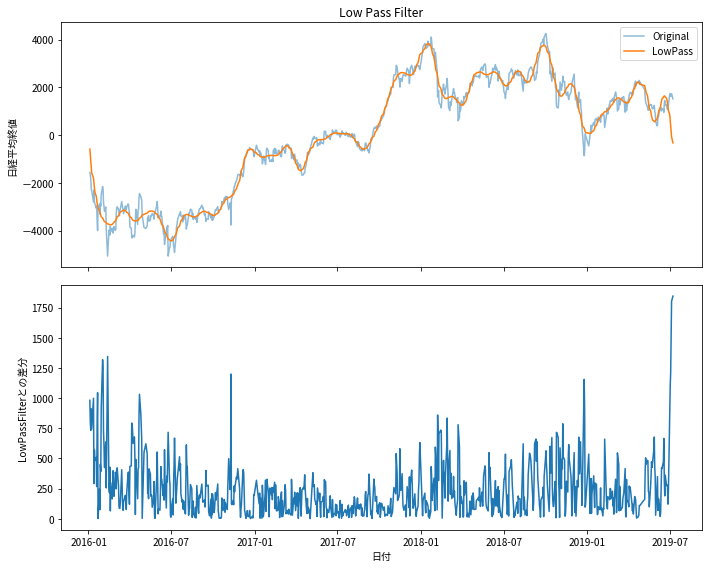

In [22]:
# 30日以下の周期を無視する様な lowpass
threshold_period = 30
threshold_freq = 1 / threshold_period

z_lowpass = np.where(abs(freq) > threshold_freq, 0, z)
y_lowpass = ifftn(z_lowpass).real

fig, axes = plt.subplots(figsize=(10, 8), nrows=2, sharex=True)
ax = axes[0]
ax.plot(x, y, '-', label='Original', alpha=.5)
ax.plot(x, y_lowpass, label='LowPass')
ax.set_title('Low Pass Filter')
ax.legend()
ax.set_ylabel('日経平均終値')

diff = y_lowpass - y
ax = axes[1]
ax.plot(x, abs(diff))
ax.set_ylabel('LowPassFilterとの差分')
ax.set_xlabel('日付')
fig.tight_layout()

save_fig(fig, name='nikkei_diff_lowpass_and_original.png')

やはり周期性が成り立っていないものに対して端の値を合わせようとしているために 2016-01 と 2017-07 の値は差分が大きいです。  
このような端点も見るためにはスペクトログラムとか使う必要がありそうです。(スペクトログラムは局所的な幅 (window) の中で FFT をいくつもやるようなイメージです。なので波形全体で周期性がなくてもそれなりに上手くやってくれます。)

ぱっと目立つのは 2016年にひとつ有る大きな暴落と2019年になるあたりでの急上昇と急降下でしょうか。

In [23]:
_df = pd.DataFrame([diff, x], index=['diff', 'date']).T.sort_values('diff', ascending=False)

In [24]:
_df.head(10)

diff                 date
27   1345.16  2016-02-12 00:00:00
209  1199.49  2016-11-09 00:00:00
733  1155.33  2018-12-25 00:00:00
12   1044.84  2016-01-21 00:00:00
5    998.391  2016-01-12 00:00:00
0    981.503  2016-01-04 00:00:00
3    910.682  2016-01-07 00:00:00
734  907.997  2018-12-26 00:00:00
514  859.389  2018-02-06 00:00:00
1    802.091  2016-01-05 00:00:00

In [25]:
_df.tail(10)

diff                 date
854  -866.97  2019-07-01 00:00:00
18  -922.626  2016-01-29 00:00:00
76  -1031.42  2016-04-22 00:00:00
855 -1099.33  2019-07-02 00:00:00
856    -1208  2019-07-03 00:00:00
20  -1247.26  2016-02-02 00:00:00
19  -1318.26  2016-02-01 00:00:00
857 -1510.47  2019-07-04 00:00:00
858 -1802.45  2019-07-05 00:00:00
859 -1844.78  2019-07-08 00:00:00